# Open Data: Berlin Kitas

In this notebook I want to explore some data I found on the Berlin Open Data portal [https://daten.berlin.de](https://daten.berlin.de/). The [data source](https://daten.berlin.de/datensaetze/kitas-berlin) contains information of Kitas (Kindertagesstätte, i.e. kindergartens) in Berlin. This is a big topic as finding a spot in a Kita is extermely difficult. We first provide an initial exploratory data analysis of the data set, then we merge it with population data to create some geo-location maps. In our way we do not expect to answer on *how to find a Kita*, but rather simpler questions about their location, distribution and sizes. 

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'png'

## Read Data

Let us load the data from the orignial Excel file (which I store locally). 

In [2]:
kitas_raw_df = pd.read_excel(
    io='../Data/kitaliste_aktuell.xlsx', 
    skiprows=4, 
    dtype={'PLZ': str}
)

In [3]:
kitas_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Betreuungsbezirk Nr  2739 non-null   int64  
 1   Betreuungsbezirk     2739 non-null   object 
 2   Einrichtungsnummer   2739 non-null   int64  
 3   Einrichtungsname     2739 non-null   object 
 4   Einrichtungsadresse  2739 non-null   object 
 5   PLZ                  2739 non-null   object 
 6   Ort                  2739 non-null   object 
 7   Telefon              2708 non-null   object 
 8   Anzahl Plätze        2736 non-null   float64
 9   Einrichtungsart      2739 non-null   object 
 10  Trägernummer         2739 non-null   int64  
 11  Trägername           2739 non-null   object 
 12  Trägerart            2739 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 278.3+ KB


## Format Data

Next, we format the data and prepare it for the analysis. 

In [4]:
# We verify there is just one city.
kitas_raw_df['Ort'].unique()

array(['Berlin'], dtype=object)

In [5]:
# There is a 1-1 correspondece between `Betreuungsbezirk Nr` and `Betreuungsbezirk`.
kitas_raw_df[['Betreuungsbezirk Nr', 'Betreuungsbezirk']].drop_duplicates()

Betreuungsbezirk Nr            Betreuungsbezirk
0                       1                       Mitte
329                     2    Friedrichshain-Kreuzberg
620                     3                      Pankow
994                     4  Charlottenburg-Wilmersdorf
1261                    5                     Spandau
1403                    6         Steglitz-Zehlendorf
1602                    7        Tempelhof-Schöneberg
1863                    8                    Neukölln
2096                    9            Treptow-Köpenick
2287                   10         Marzahn-Hellersdorf
2420                   11                 Lichtenberg
2581                   12               Reinickendorf

In [6]:
# Rename columns from German to English.
rename_cols = {
    'Betreuungsbezirk': 'district',
    'Einrichtungsnummer': 'id',
    'Einrichtungsname': 'name',
    'Einrichtungsadresse': 'address',
    'PLZ': 'plz',                  
    'Telefon': 'telephone',       
    'Anzahl Plätze': 'spots'  ,
    'Einrichtungsart': 'type',
    'Trägernummer': 'carrier_number',
    'Trägername': 'carrier_name',  
    'Trägerart': 'carrier_type',
}

columns_to_drop = [
    'Betreuungsbezirk Nr', 
    'Ort',
]

# Format data: remove redundant columns, rename columns and add new features.
kitas_df = kitas_raw_df \
    .copy() \
    .drop(columns_to_drop, axis=1) \
    .rename(columns=rename_cols) \
    .assign(
        num_kitas_plz=lambda x: x.groupby(['district', 'plz'])['id'].transform('count'),
        spots_plz=lambda x: x.groupby(['district', 'plz'])['spots'].transform(np.sum)
    )
    
kitas_df.head()

district       id                               name  \
0    Mitte  1010010                  Kita F.A.I.R.play   
1    Mitte  1010020                    Kita Kinderwelt   
2    Mitte  1010030  FRÖBEL Kindergarten Casa Fantasia   
3    Mitte  1010080                    Kita Regenbogen   
4    Mitte  1010100  FRÖBEL Kindergarten "Schatzinsel"   

                  address    plz  telephone  spots               type  \
0        Albrechtstr. 020  10117  281 64 73   69.0  Kindertagesstätte   
1  An der Kolonnade 003-5  10117    2291378  155.0  Kindertagesstätte   
2       Anklamer Str. 038  10115    4498171   69.0  Kindertagesstätte   
3   Fehrbelliner Str. 080  10119  449 32 38   91.0  Kindertagesstätte   
4        Fischerinsel 008  10179  201 37 88  241.0  Kindertagesstätte   

   carrier_number                                       carrier_name  \
0            1224  GFJ - gemeinnützige Gesellschaft für Familien-...   
1            1334                         Forum Soziale Dienste GmbH   
2            1227                 Fröbel Bildung und Erziehung gGmbH   
3            1202                      Pfefferwerk Stadtkultur gGmbH   
4            1227                 Fröbel Bildung und Erziehung gGmbH   

              carrier_type  num_kitas_plz  spots_plz  
0  Sonstiger freier Träger             21     1550.0  
1  Sonstiger freier Träger             21     1550.0  
2  Sonstiger freier Träger             24     1807.0  
3  Sonstiger freier Träger             11     1150.0  
4  Sonstiger freier Träger             10      939.0

## Exploratory Data Analysis

One of the main objectives of this notebook is to do an exploratory data analysis to understand which questions this data set can answer. In addition, also determine its limitations. To begin, let us get the number of unique values per feature. 

In [7]:
kitas_df.apply(lambda x: x.unique().size, axis=0)

district            12
id                2739
name              2597
address           2707
plz                190
telephone         2601
spots              200
type                 4
carrier_number    1224
carrier_name      1224
carrier_type         8
num_kitas_plz       37
spots_plz          194
dtype: int64

In [8]:
# Dimensions data set.
kitas_df.shape

(2739, 13)

We have 2739 Kitas in our data set and the `id` column is indeed an unique identifier of each Kita. The name, on the other hand, is not. 

In [9]:
kitas_df \
    .groupby(['name']) \
    .agg(num_kitas=('id', 'count')) \
    .query('num_kitas > 1') \
    .sort_values('num_kitas', ascending=False) \
    .head()

num_kitas
name                                    
Kleiner Fratz                         18
IB-Kita, Internationaler Bund          8
Kita/Kinder in Bewegung (KiB)          6
Kita Sonnenschein                      5
Kita Kinder in Bewegung (KiB)          5

### Kitas per District

We start by looking into the first layer of geo-location granularity: `district` (there are 12 districts in Berlin).

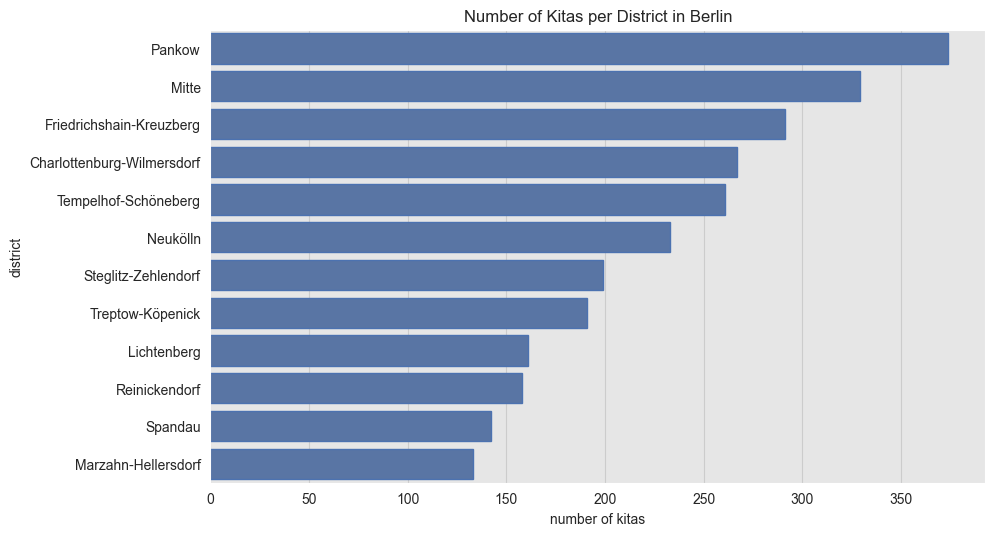

In [10]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin', 
    xlabel='number of kitas', 
    ylabel='district'
);

We generate the same plot but showing the shares instead. 

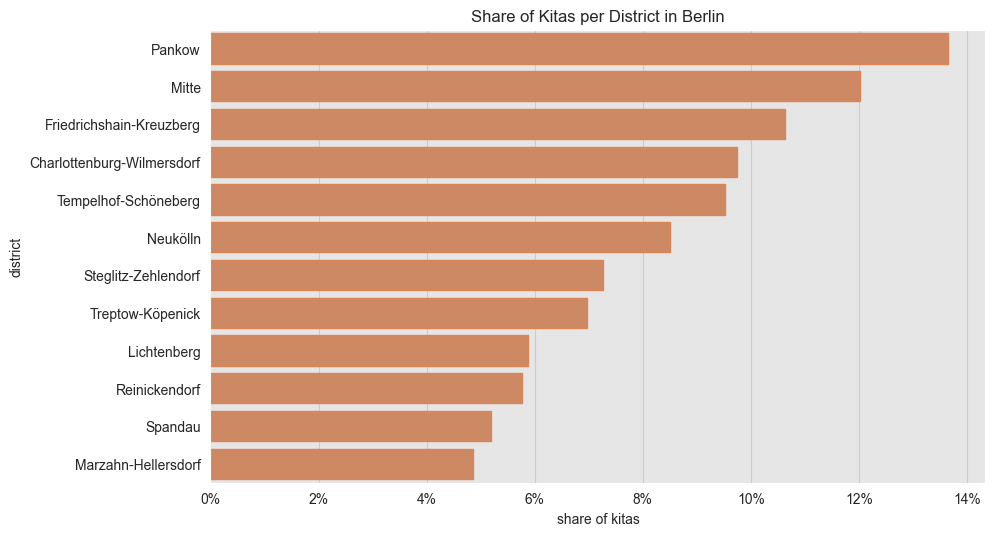

In [11]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='district',
        color=sns_c[1],
        edgecolor=sns_c[1],
        ax=ax
    )
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:0.0%}'.format(y)))
ax.set(
    title='Share of Kitas per District in Berlin', 
    xlabel='share of kitas', 
    ylabel='district'
);

Pankow is a rather big district compared to Mitte and Friedrichshain-Kreuzberg area-wise. In order to run a fair comparison across districts, we need to control by size or population (which we will do bellow).

### Kitas per PLZ

Now we dig deeper into `plz` level. A natural question is: *How many Kitas each `plz` has?* To answer it let us look into the distribution (again, in order to make a fair comparison we need to control by `plz` population or size).

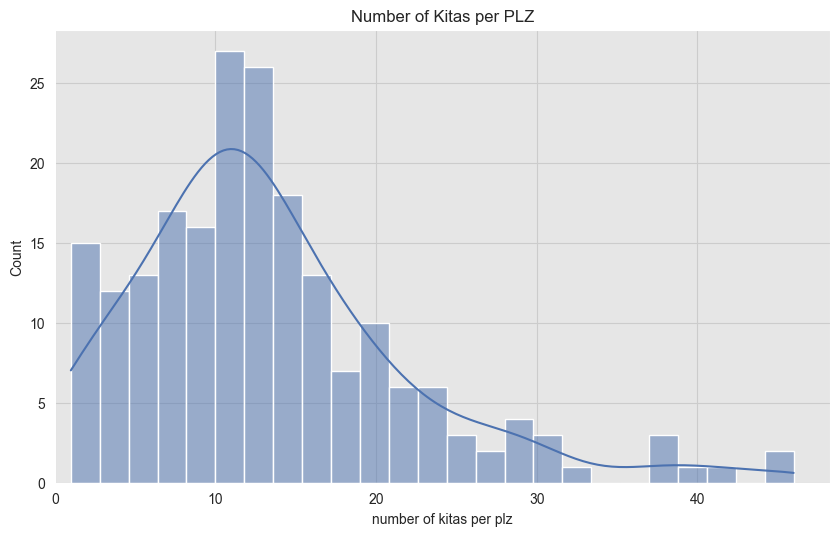

In [12]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .pipe((sns.histplot, 'data'),
        x='n', 
        bins=25, 
        kde=True,
        ax=ax
    )
ax.set(
    title='Number of Kitas per PLZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

We see there is a long tail. Let us see the `plz` with more Kitas:

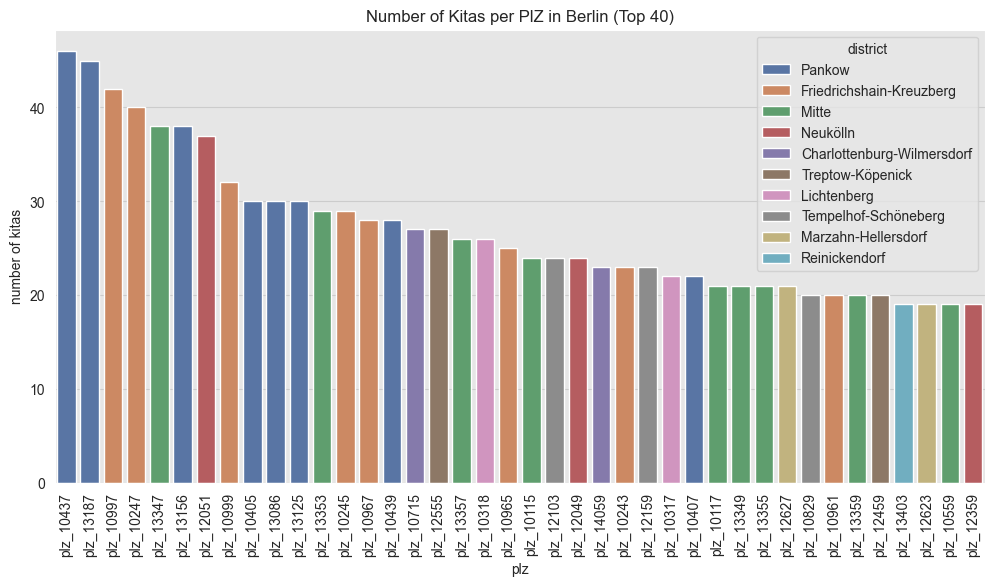

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .assign(plz = lambda x: 'plz_' + x['plz']) \
    .sort_values('n', ascending=False) \
    .head(40) \
    .pipe((sns.barplot, 'data'),  
        x='plz',
        y='n',
        hue='district',
        dodge=False,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin (Top 40)', 
     xlabel='plz', 
     ylabel='number of kitas', 
);

Let us locate `plz` = 10437 using Google maps.

<div style="width: 100%">
    <iframe width="100%" height="600" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://maps.google.com/maps?width=100%25&amp;height=600&amp;hl=en&amp;q=Berlin%2010437+(Berlin%2010437)&amp;t=&amp;z=14&amp;ie=UTF8&amp;iwloc=B&amp;output=embed">
    </iframe>
</div>

This is a very trendy area in Berlin, specially for young families. 

Next, let us plot the distribution of the number of Kitas per `plz` split by `district`.

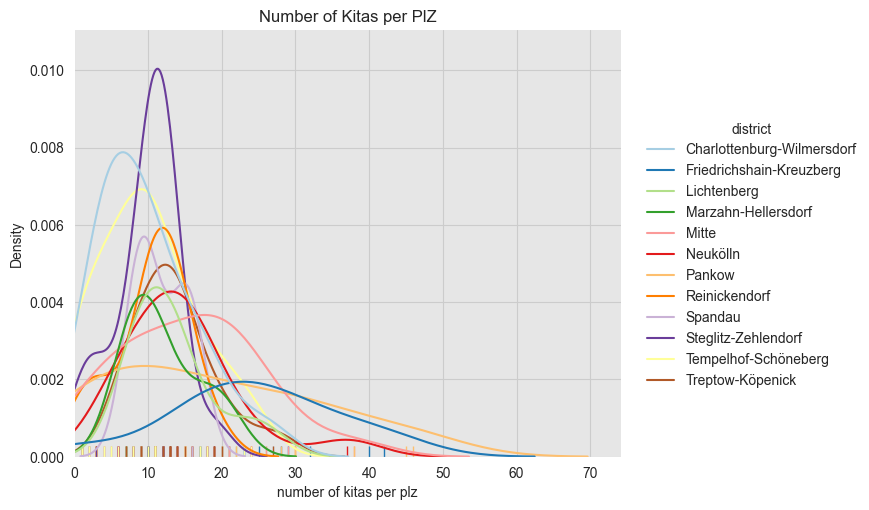

In [14]:
g = kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .pipe((sns.displot, 'data'), 
        x='n',
        hue='district',
        kind='kde',
        rug=True, 
        height=5,
        aspect=1.3,
        palette='Paired'
    )
ax = g.axes.flatten()[0]
ax.set(
    title='Number of Kitas per PlZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

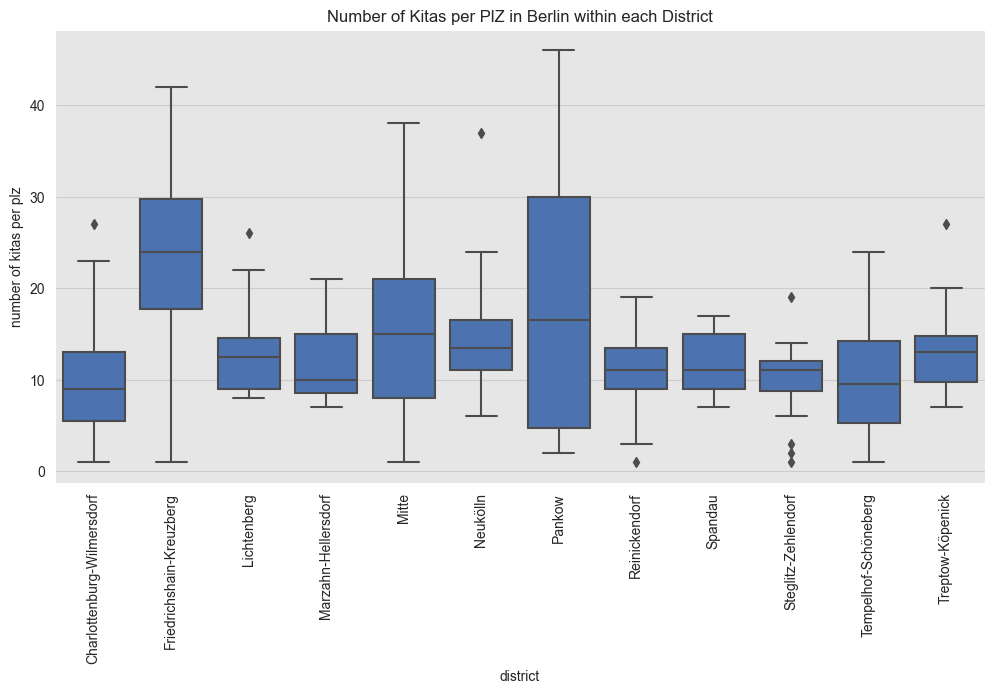

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('district') \
    .pipe((sns.boxplot, 'data'), 
        x='district', 
        y='n',
        color=sns_c[0],
        saturation=1.0,
        ax=ax
    )

ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin within each District', 
     ylabel='number of kitas per plz', 
);

It seems that, on average, Friedrichshain-Kreuzberg have more Kitas per `plz` and Pankow has the highest variance (again, we need to control by `plz` size to be more precise).

### Spots per Kita

Let us now analyze the number of spots data. 

In [16]:
# Some descriptive stats.
kitas_df['spots'].describe()

count    2736.000000
mean       67.617690
std        55.624663
min         0.000000
25%        25.000000
50%        45.000000
75%        95.000000
max       320.000000
Name: spots, dtype: float64

Note that there is a Kita wih `spots`=0. I am not sure about the reason behind this. 

In [17]:
kitas_df.query('spots == 0')

district       id         name            address  \
1122  Charlottenburg-Wilmersdorf  4073100  Dickenskita  Dickensweg 017-19   

        plz telephone  spots               type  carrier_number  \
1122  14055  35109330    0.0  Kindertagesstätte            8435   

                     carrier_name             carrier_type  num_kitas_plz  \
1122  Berlin British School gGmbH  Sonstiger freier Träger             11   

      spots_plz  
1122      500.0

We plot the `spots` distribution:

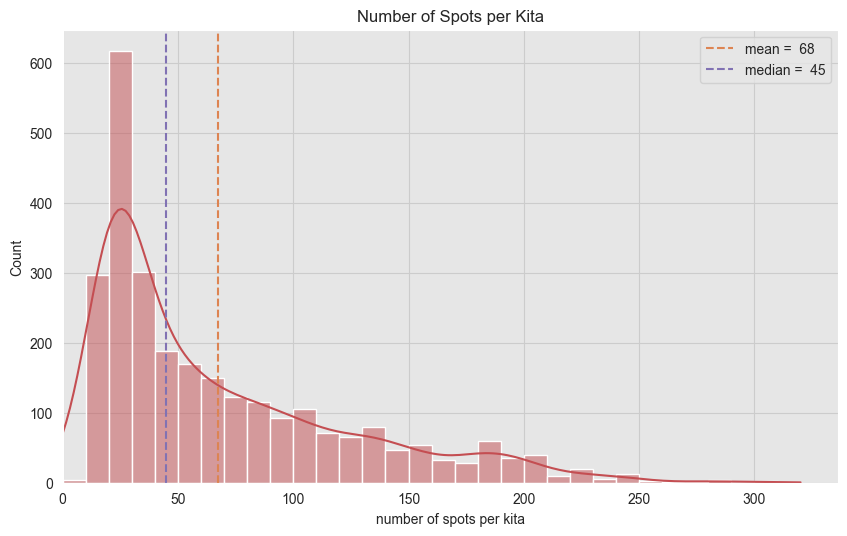

In [18]:
spots_mean = kitas_df['spots'].describe()['mean']
spots_median = kitas_df['spots'].describe()['50%']

fig, ax = plt.subplots()
sns.histplot(x='spots', data=kitas_df, kde=True, color=sns_c[3], ax=ax)
ax.axvline(x=spots_mean, color=sns_c[1], linestyle='--', label=f'mean = {spots_mean: 0.0f}')
ax.axvline(x=spots_median, color=sns_c[4], linestyle='--', label=f'median = {spots_median: 0.0f}')
ax.legend(loc='upper right')
ax.set(
    title='Number of Spots per Kita', 
     xlabel='number of spots per kita',
     xlim=(0, None)
);

Here is a list of the top 20 kitas with more spots:

In [19]:
kitas_df \
    [['name', 'district', 'plz', 'spots']] \
    .sort_values('spots', ascending=False) \
    .head(20) 

name  \
54                           BCS Kindergarten Preschool   
2441                                 Kita Lichtenzwerge   
2428                                   Kita Bärenkinder   
2543         Kita Neustrelitzer Str. 32-34/Kigä NordOst   
2113                      FRÖBEL Kindergarten-im-Grünen   
647   Klax Krippen Regentropfenhaus und Wolkenzwerge...   
1885                        Kita Mini-Mix-International   
351                         FRÖBEL Kindergarten Am Ring   
14                FRÖBEL Kindergarten "Traumzauberbaum"   
2590                       Kita Treuenbrietzener Straße   
2541                                  Kita Nido Piccolo   
2566                                 Kita Tausendfüßler   
329                        Kita Spiel- und Erlebniswelt   
346                   FRÖBEL Kindergarten FRÖBELSPATZEN   
864                                 Kita Am Brennerberg   
4                     FRÖBEL Kindergarten "Schatzinsel"   
2115                     FRÖBEL Kindergarten Wirbelwind   
335                             Kita Gryphiusstr. 34-35   
2460                             Kita Bunte Plonzstifte   
901   Klax Krippe Sonnenhaus,Klax Kindergarten Wolke...   

                      district    plz  spots  
54                       Mitte  10115  320.0  
2441               Lichtenberg  10315  300.0  
2428               Lichtenberg  10319  300.0  
2543               Lichtenberg  13055  285.0  
2113          Treptow-Köpenick  12487  282.0  
647                     Pankow  10439  280.0  
1885                  Neukölln  12053  280.0  
351   Friedrichshain-Kreuzberg  10247  272.0  
14                       Mitte  10178  260.0  
2590             Reinickendorf  13439  252.0  
2541               Lichtenberg  13059  250.0  
2566               Lichtenberg  13055  250.0  
329   Friedrichshain-Kreuzberg  10243  248.0  
346   Friedrichshain-Kreuzberg  10243  246.0  
864                     Pankow  13187  245.0  
4                        Mitte  10179  241.0  
2115          Treptow-Köpenick  12435  240.0  
335   Friedrichshain-Kreuzberg  10245  240.0  
2460               Lichtenberg  10365  240.0  
901                     Pankow  13189  240.0

Let us see the `spots` distributoin per district:

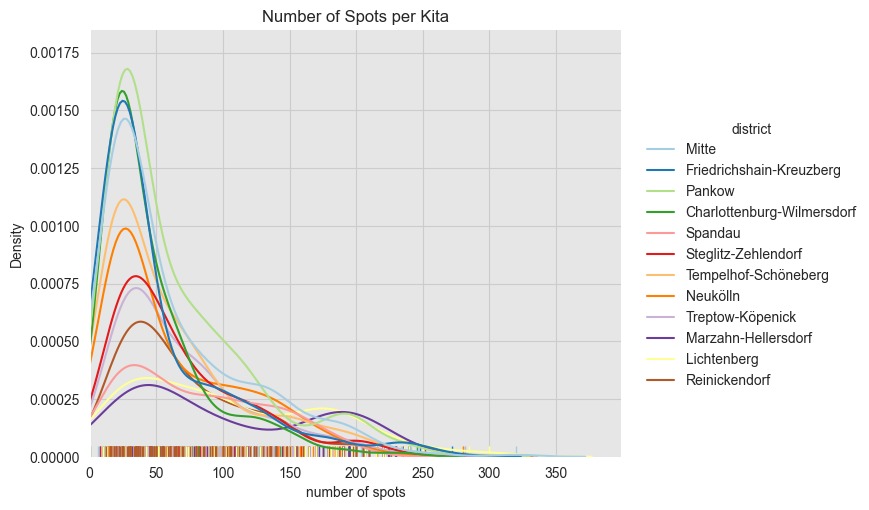

In [20]:
g = kitas_df \
    .pipe((sns.displot, 'data'), 
        x='spots',
        hue='district',
        kind='kde',
        rug=True, 
        height=5,
        aspect=1.3,
        palette='Paired'
    )
ax = g.axes.flatten()[0]
ax.set(
    title='Number of Spots per Kita', 
    xlabel='number of spots', 
    xlim=(0, None)
);

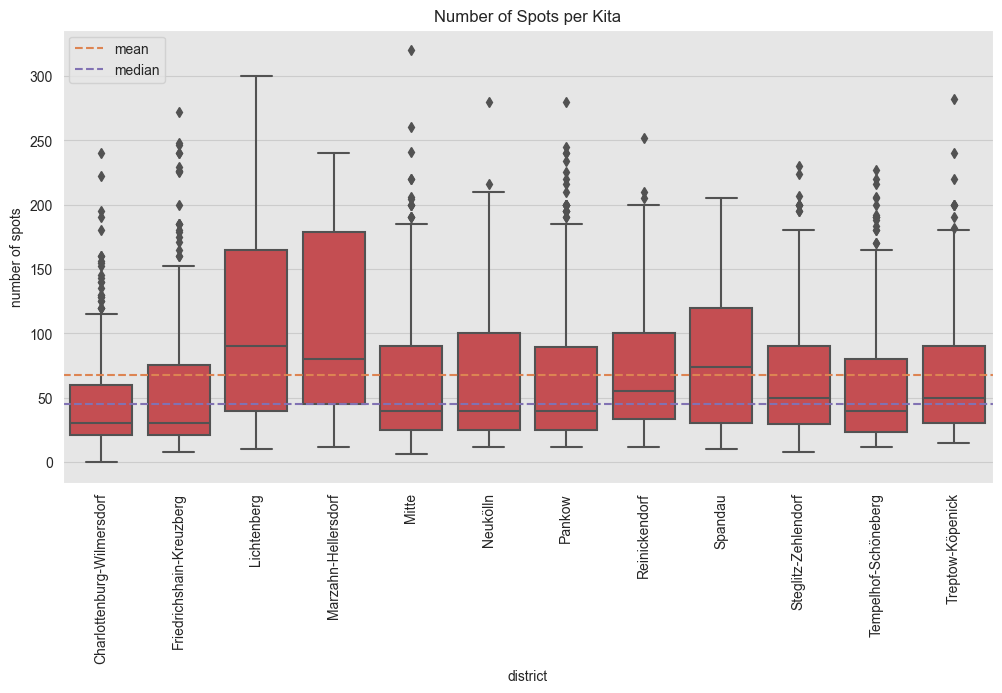

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

kitas_df \
    .sort_values('district') \
    .pipe((sns.boxplot, 'data'), 
        x='district', 
        y='spots', 
        color=sns_c[3],
        saturation=1.0,
        ax=ax
    )
ax.axhline(y=kitas_df['spots'].describe()['mean'], color=sns_c[1], linestyle='--', label='mean')
ax.axhline(y=kitas_df['spots'].describe()['50%'], color=sns_c[4], linestyle='--', label='median')
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='upper left')
ax.set(
    title='Number of Spots per Kita', 
     ylabel='number of spots', 
);

Note that Pankow, Mitte and Friedrichshain-Kreuzberg have a lowe number of spots per Kita (these are the top 3 districts with mote Kitas). We want to see if there is a linear relation between the number of Kitas per `plz` and the number (median) of spots per Kita.

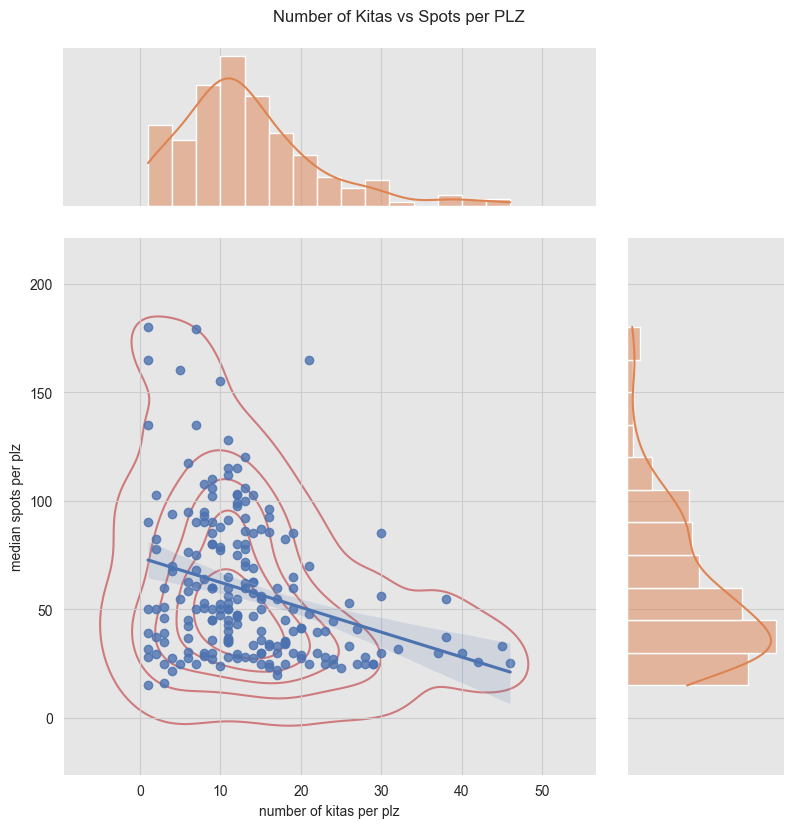

In [22]:
g = kitas_df \
    .groupby(['district', 'plz']) \
    .agg({'num_kitas_plz': np.mean, 'spots': np.median}) \
    .pipe((sns.jointplot, 'data'), 
        x='num_kitas_plz',  
        y='spots',
        kind='reg', 
        order=1,
        height=8,
        ratio=3, 
        marginal_kws=dict(color=sns_c[1])
    )
g.plot_joint(sns.kdeplot, zorder=0, levels=6, color=sns_c[3], alpha=0.7)
g.set_axis_labels(xlabel='number of kitas per plz', ylabel='median spots per plz')
g.fig.suptitle('Number of Kitas vs Spots per PLZ', y=1.03);

It seems there is a negative relation between them, i.e. `plz` with more Kitas seem to have less `spots` per Kita. Let us plot this per `district`: 

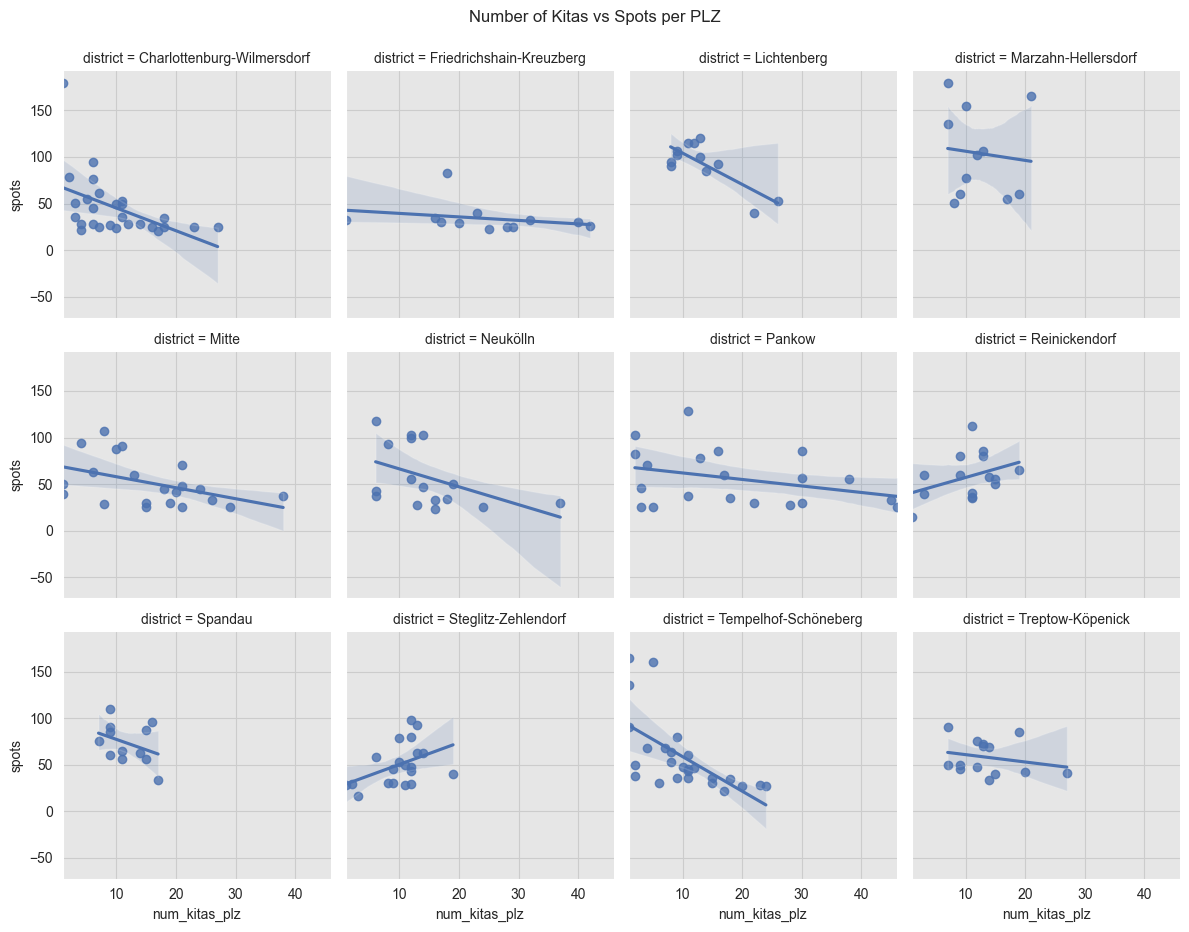

In [23]:
g = kitas_df \
    .groupby(['district', 'plz'], as_index=False) \
    .agg({'num_kitas_plz': np.mean, 'spots': np.median}) \
    .pipe((sns.FacetGrid, 'data'),
        col='district', 
        col_wrap=4, 
        height=3,
    )
g.map(sns.regplot, 'num_kitas_plz', 'spots')
g.fig.suptitle('Number of Kitas vs Spots per PLZ', y=1.03);

### Carriers

Now we want to study the `carrier` feature. First, let us count the number of kitas per `carrier_type`.

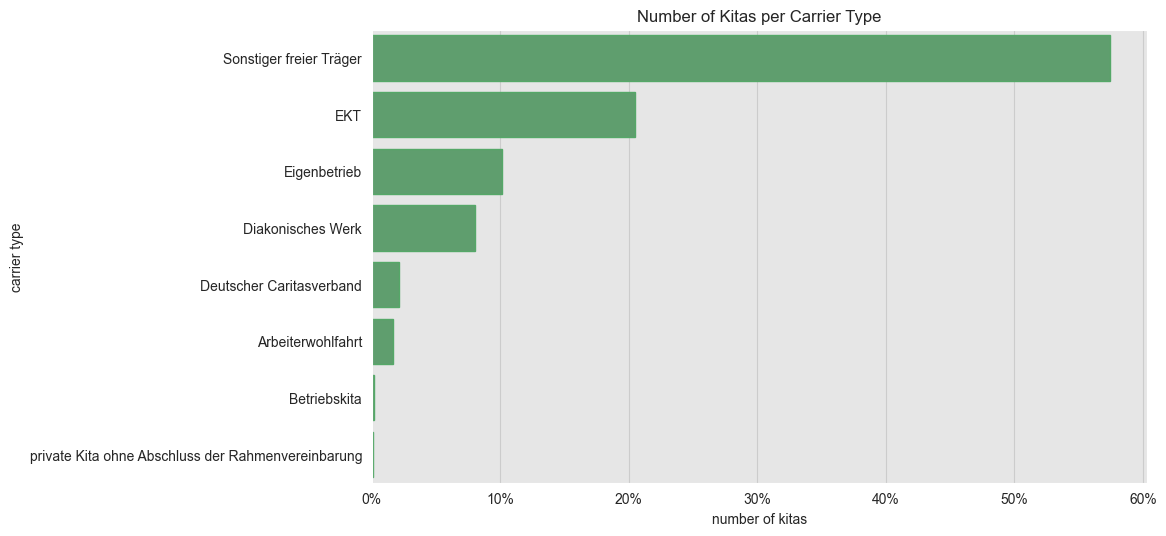

In [24]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index() \
    .sort_values('n', ascending=False) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='carrier_type',
        color=sns_c[2],
        edgecolor=sns_c[2],
        ax=ax
    )
fmt = lambda y, _: f'{y :0.0%}'
ax.xaxis.set_major_formatter(mtick.FuncFormatter(fmt))
ax.set(
    title='Number of Kitas per Carrier Type', 
    xlabel='number of kitas', 
    ylabel='carrier type'
);

Here are some explanations on the `carrier_type`:

- Arbeiterwohlfahrt: Workers welfare
- Betriebskita: Company daycare
- Deutscher Caritasverband: German Caritas Association
- Eigenbetrieb: Own operation
- EKT (Eltern-Initiativ-Kindertagesstätte): Parents initiative. 
- Diakonisches Werk: Diaconal work
- private Kita ohne Abschluss der Rahmenvereinbarung: private daycare without signing the framework agreement
- Sonstiger freier Träger: Other private carrier

In [25]:
# Note that there is. a 1-1 correspondence between `carrier_number` and `carrier_name`.
kitas_df \
    .groupby('carrier_number')\
    .agg({'carrier_name': 'nunique'}) \
    .query('carrier_name > 1') \
    .shape

(0, 1)

Now we plot the `carrier_type` distriibution per `district`.

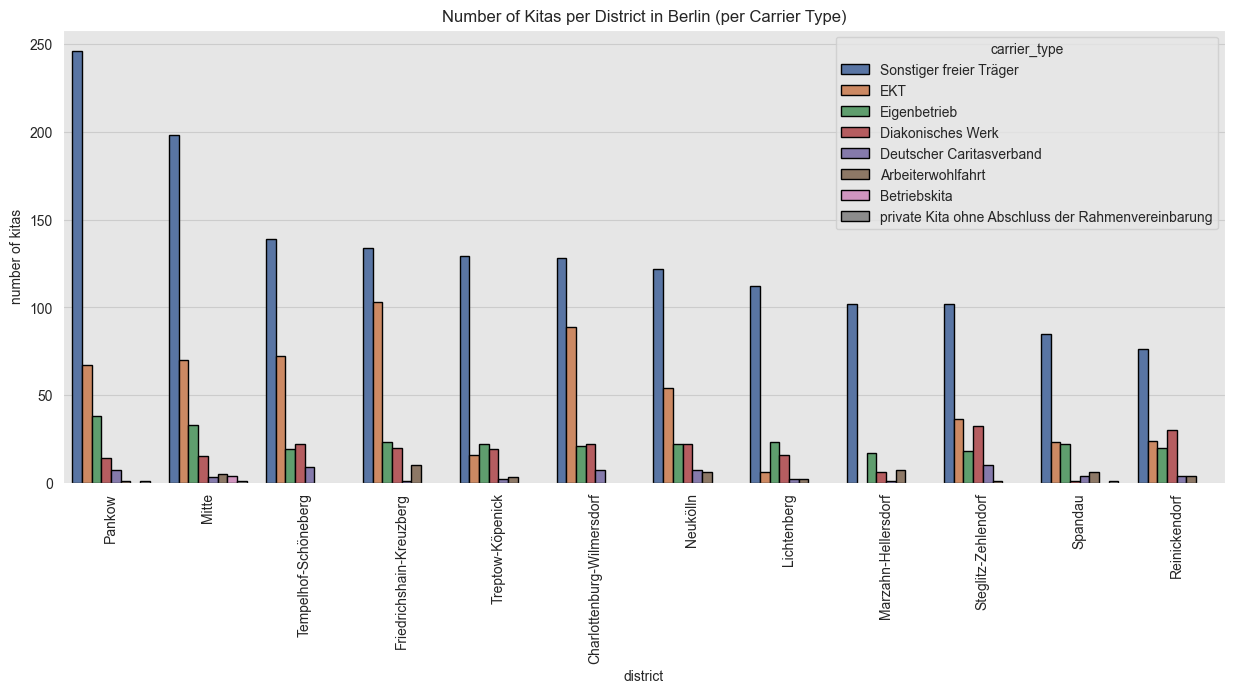

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        y='n', 
        x='district',
        hue='carrier_type',
        edgecolor='black',
        dodge=True,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per District in Berlin (per Carrier Type)', 
    xlabel='district', 
    ylabel='number of kitas'
);

We can also compute `carrier_type` share per `district`: 

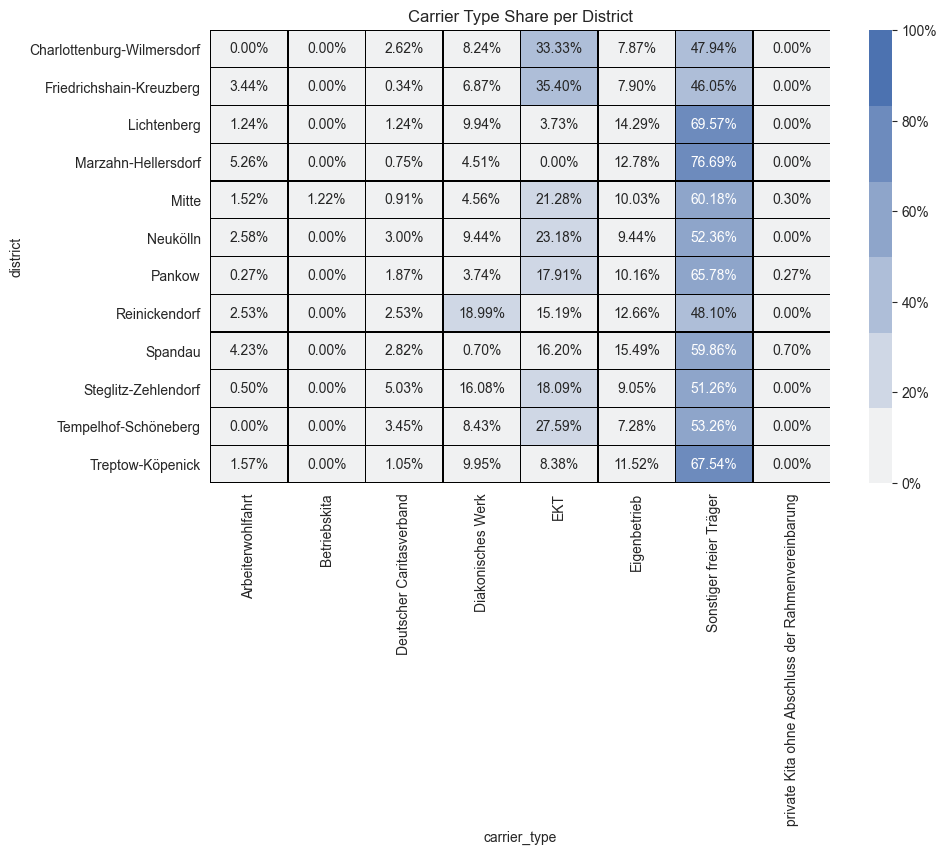

In [27]:
fig, ax = plt.subplots()

cmap = sns.light_palette(sns_c[0])

fmt = lambda y, _: f'{y :0.0%}'

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .assign(
        num_kitas_district = lambda x: x.groupby(['district'])['n'].transform(np.sum),
        share = lambda x: x['n'].div(x['num_kitas_district'])
    ) \
    .pivot(index='district', columns='carrier_type', values='share') \
    .fillna(0.0) \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax
    )

ax.set(title='Carrier Type Share per District');

It is very  interesting to see how high the share of *EKT* in Charlottenburg-Wilmersdorf and Friedrichshain-Kreuzberg.

Now we want to investigate the carriers coverage on the number of Kitas. The questions we want to answer are: 

1. Do carriers with more than one Kita dominate the Kita distribution?

2. Do we see a difference across districts? 

To answer both question we need to compute how many kitas each carrier has. In addition,we sort them out by the number of Kitas calculate the (cumulative) share on the number of Kitas. This will allow us to answer the first question.

In [28]:
carrier_df = kitas_df \
    .groupby(['carrier_name']) \
    .agg(num_kitas=('name', pd.Series.nunique)) \
    .sort_values('num_kitas', ascending=False) \
    .assign(
        single_kita = lambda x: x['num_kitas'] < 2,
        share = lambda x: x['num_kitas'] / x['num_kitas'].sum(),
        cumsum_share = lambda x: x['share'].cumsum(),
        idx= lambda x: range(x.shape[0])
    )

carrier_df.head()

num_kitas  single_kita  \
carrier_name                                                                 
Kindergärten NordOst                                       77        False   
Kindertagesstätten Nordwest Eigenbetrieb von Be...         63        False   
Kindergärten City                                          56        False   
Kindertagesstätten SüdOst Eigenbetrieb von Berlin          44        False   
Kindertagesstätten Berlin Süd-West                         37        False   

                                                       share  cumsum_share  \
carrier_name                                                                 
Kindergärten NordOst                                0.029079      0.029079   
Kindertagesstätten Nordwest Eigenbetrieb von Be...  0.023792      0.052870   
Kindergärten City                                   0.021148      0.074018   
Kindertagesstätten SüdOst Eigenbetrieb von Berlin   0.016616      0.090634   
Kindertagesstätten Berlin Süd-West                  0.013973      0.104607   

                                                    idx  
carrier_name                                             
Kindergärten NordOst                                  0  
Kindertagesstätten Nordwest Eigenbetrieb von Be...    1  
Kindergärten City                                     2  
Kindertagesstätten SüdOst Eigenbetrieb von Berlin     3  
Kindertagesstätten Berlin Süd-West                    4

Let us compute the distribution of carriers with a single Kita vs carriers with more than one Kita.

In [29]:
carrier_df \
    .groupby('single_kita')\
    .agg(n=('idx', 'count')) \
    .assign(share=lambda x: x['n'].div(x['n'].sum()))

n     share
single_kita               
False        365  0.298203
True         859  0.701797

Next we plot the cumulative share data on the number of Kitas:

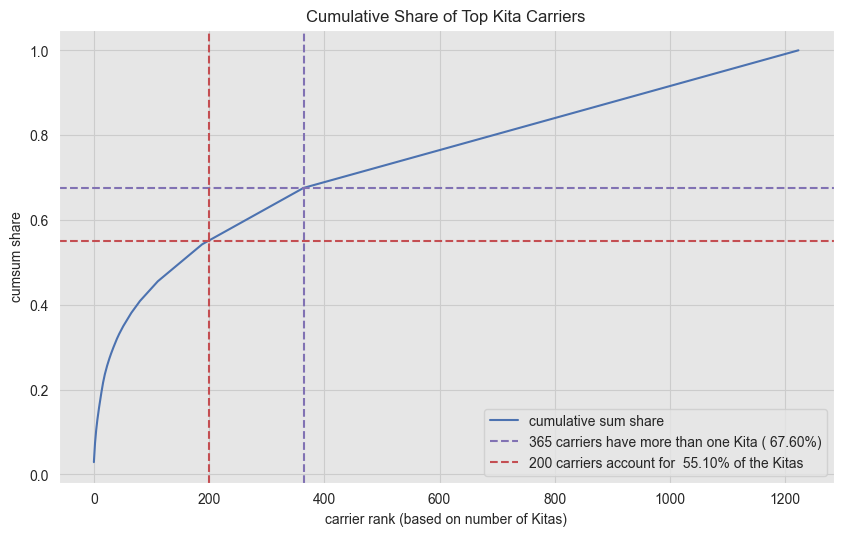

In [30]:
k = 200 
k_cumsum_share = carrier_df.query(f'idx == {k - 1}')['cumsum_share'].values[0]
idx_single_kita = carrier_df.query('single_kita').iloc[0]['idx']
cumsum_share_single_kita = carrier_df.query('single_kita').iloc[0]['cumsum_share']

fig, ax = plt.subplots()
sns.lineplot(x='idx', y='cumsum_share', data=carrier_df, color=sns_c[0], label='cumulative sum share', ax=ax)
ax.axvline(x=idx_single_kita, color=sns_c[4], linestyle='--', label=f'{idx_single_kita} carriers have more than one Kita ({cumsum_share_single_kita: 0.2%})')
ax.axhline(y=cumsum_share_single_kita, color=sns_c[4], linestyle='--')
ax.axvline(x=k, color=sns_c[3], linestyle='--', label=f'{k} carriers account for {k_cumsum_share: 0.2%} of the Kitas')
ax.axhline(y=k_cumsum_share , color=sns_c[3], linestyle='--')
ax.legend(loc='lower right')
ax.set(
    title='Cumulative Share of Top Kita Carriers', 
    xlabel='carrier rank (based on number of Kitas)',
    ylabel='cumsum share'
);

We have two main takeaways from this plot:

1. 356 carriers, which are ~ 30% of the total number of carriers, cover ~ 67% of the number of Kitas. 

2. The top 200 carriers, which are ~ 16% of the total number of carriers, cover more than half (~ 55%) of the number of Kitas.

Hence, the carriers. with more than one Kita have a very high coverage. 

In [31]:
# We merge the carriers data to. the Kitas data.
kitas_df = pd.merge(
    left=kitas_df, 
    right=carrier_df['single_kita'].reset_index(), 
    on='carrier_name', 
    how='left'
)

Now let us answer the second question by looking into the districts.

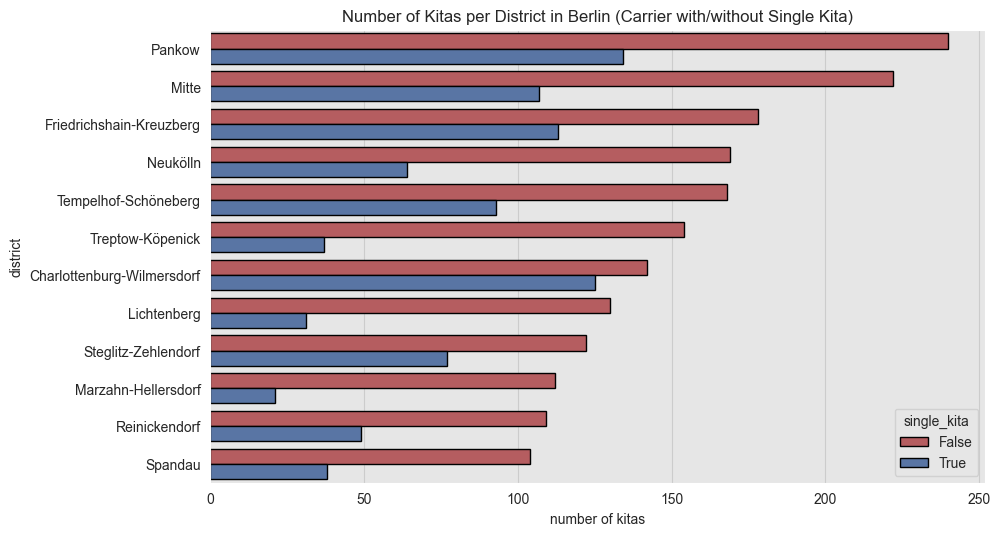

In [32]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        hue='single_kita',
        edgecolor='black',
        palette=[sns_c[3], sns_c[0]],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin (Carrier with/without Single Kita)', 
    xlabel='number of kitas', 
    ylabel='district'
);

We now plot the relative share over districts of number of Kitas ans spots (which are of course correlated):

In [33]:
carrier_kitas_df = kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count'), spots=('spots', np.sum)) \
    .reset_index(drop=False) \
    .sort_values('district') \
    .assign(
        total_n = lambda x: x.groupby('district')['n'].transform(np.sum),
        total_spots = lambda x: x.groupby('district')['spots'].transform(np.sum),
        share_n = lambda x: x['n'].div(x['total_n']),
        share_spots = lambda x: x['spots'].div(x['total_spots']),
    )

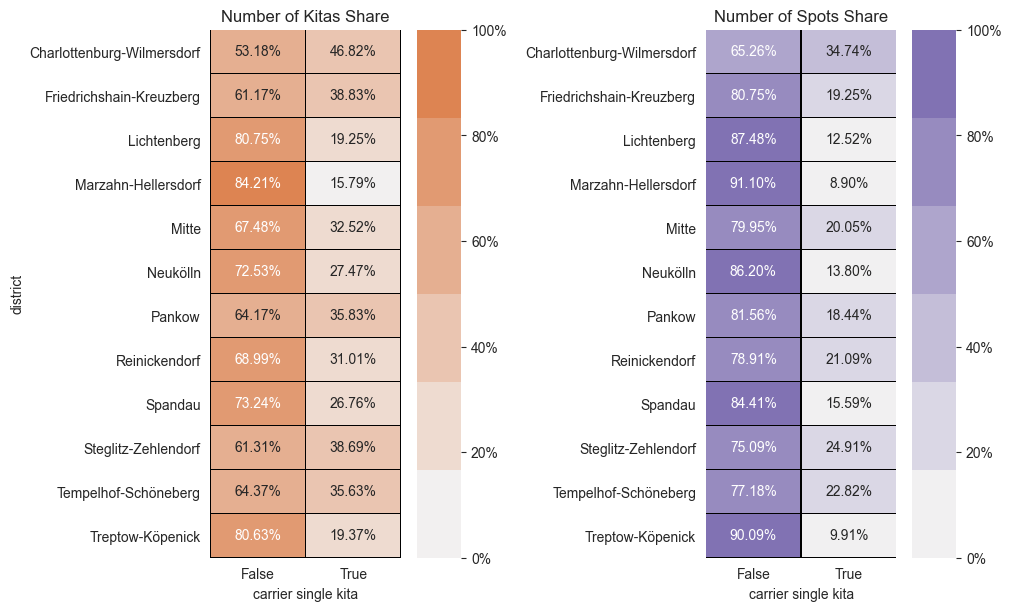

In [34]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

cmap0 = sns.light_palette(sns_c[1])
cmap1 = sns.light_palette(sns_c[4])

fmt = lambda y, _: f'{y :0.0%}'

carrier_kitas_df \
    .pivot(index='district', columns='single_kita', values='share_n') \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap0,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax[0]
    )

carrier_kitas_df \
    .pivot(index='district', columns='single_kita', values='share_spots') \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap1,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax[1]
    )

ax[0].set(title='Number of Kitas Share', xlabel='carrier single kita')
ax[1].set(title='Number of Spots Share', xlabel='carrier single kita', ylabel='');

- In Charlottenburg-Wilmersdorf the share of carriers with/without single Kitas is quite balanced whereas in Marzahn-Hellersdorf and Treptow-Köpenick is quite unbalanced. 

This ends the an initial exploratory data analysis of the Kitas data. There are still many interesting things to look, but we will leave them for a second iteration.

## Maps & Population Data

Next we enrich out data set by including information about population per `plz`. In addition, we use maps to visualize some metrics. Please refer to the blog post [Open Data: Germany Maps Viz](https://juanitorduz.github.io/germany_plots/) for the description of the data sources. 

- Geo-location Data: geo-pandas dataframe with `plz` geometries. 

In [35]:
plz_shape_df = gpd.read_file('../Data/plz-gebiete.shp', dtype={'plz': str})

plz_shape_df.head()

plz                         note  \
0  52538      52538 Gangelt, Selfkant   
1  47559             47559 Kranenburg   
2  52525  52525 Waldfeucht, Heinsberg   
3  52074                 52074 Aachen   
4  52531       52531 Ãbach-Palenberg   

                                            geometry  
0  POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...  
1  POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...  
2  POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...  
3  POLYGON ((5.97486 50.79804, 5.97495 50.79809, ...  
4  POLYGON ((6.01507 50.94788, 6.03854 50.93561, ...

- Population Data

In [36]:
plz_einwohner_df = pd.read_csv(
    '../Data/plz_einwohner.csv',
    sep=',',
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

plz  einwohner
0  01067      11957
1  01069      25491
2  01097      14811
3  01099      28021
4  01108       5876

- Merge Data

We merge these data sets on `plz`.

In [37]:
plz_df = pd.merge(
    left=plz_shape_df[['plz', 'geometry']],
    right=plz_einwohner_df,
    on='plz',
    how='left'
)
# Merge with Kitas data.
plz_df = pd.merge(
    left=plz_df,
    right=kitas_df[['district', 'plz', 'num_kitas_plz', 'spots_plz']].drop_duplicates(),
    on='plz',
    how='inner'
)
# Add features: number of kitas per plz per capita (and its log-transform).
plz_df = plz_df.assign(
    num_kitas_plz_pc = lambda x: x['num_kitas_plz'].div(x['einwohner']), 
    num_kitas_plz_pc_log = lambda x: np.log(x['num_kitas_plz_pc'])
)

plz_df.head()

plz                                           geometry  einwohner  \
0  14109  POLYGON ((13.08835 52.41963, 13.09584 52.42198...      10049   
1  14089  POLYGON ((13.10929 52.45063, 13.10956 52.45108...      17734   
2  13591  POLYGON ((13.11738 52.51706, 13.11811 52.52010...      26762   
3  13587  POLYGON ((13.12796 52.58313, 13.12934 52.58593...      20108   
4  13593  POLYGON ((13.14288 52.52181, 13.14306 52.52179...      20238   

              district  num_kitas_plz  spots_plz  num_kitas_plz_pc  \
0  Steglitz-Zehlendorf              8      357.0          0.000796   
1              Spandau             15     1112.0          0.000846   
2              Spandau             16     1595.0          0.000598   
3              Spandau             14     1113.0          0.000696   
4              Spandau              9      997.0          0.000445   

   num_kitas_plz_pc_log  
0             -7.135787  
1             -7.075189  
2             -7.422150  
3             -7.269816  
4             -7.718093

First, let us visualize the `plz` per `district` in Berlin (we plot both static and dynamic maps).

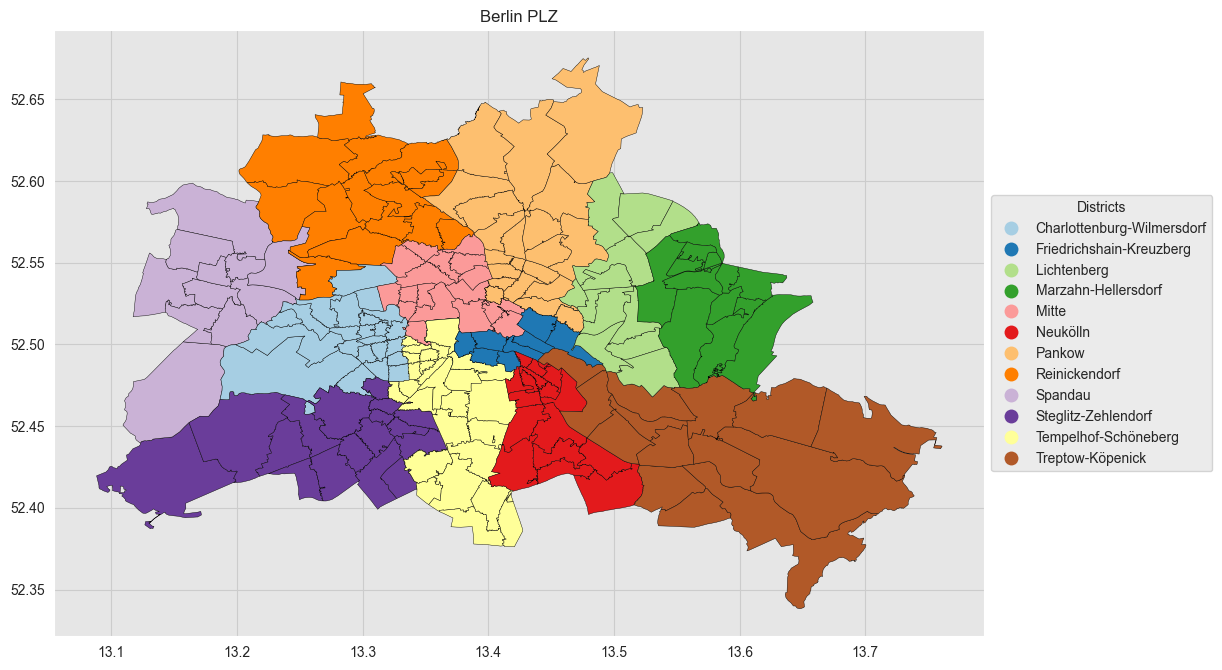

In [38]:
fig, ax = plt.subplots(figsize=(12, 9))

plz_df.plot(
    ax=ax,
    column='district',
    categorical=True,
    cmap='Paired',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'title':'Districts', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)},
)
ax.set(
    title='Berlin PLZ',
    aspect=1.3
);

In [39]:
fig, ax = plt.subplots(figsize=(12, 9))

plz_df.plot(
    ax=ax,
    column='district',
    categorical=True,
    cmap='Paired',
    edgecolor='black',
    linewidth=0.3,
)

mplleaflet.display(fig=fig)

We clearly see that the districts size in area are very different. Note for example how small Friedrichshain-Kreuzberg and Mitte (both in top 3 `districs` with more Kitas) are as compared with Treptow-Köpenick. 

Next we plot the number if inhabitants per `plz`.

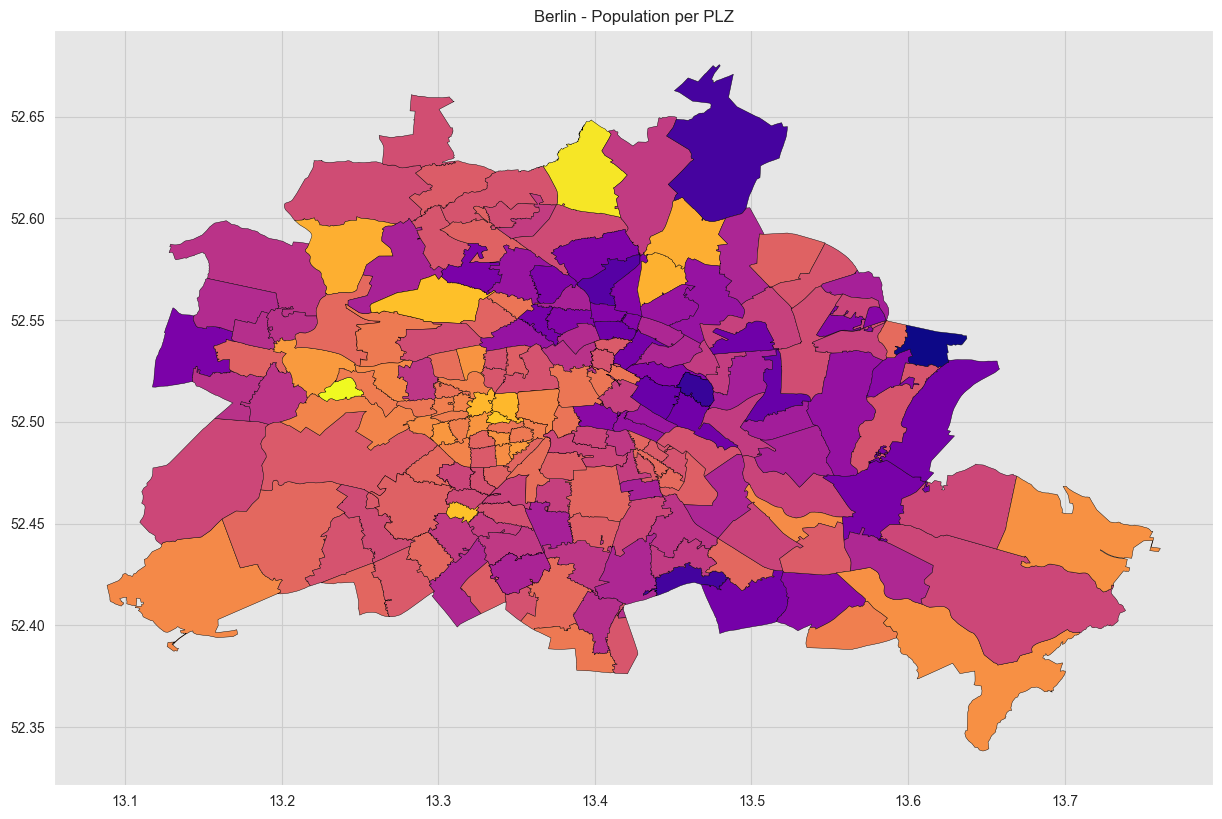

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='einwohner',  
    categorical=False, 
    cmap='plasma_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Berlin - Population per PLZ',
    aspect=1.3
);

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='einwohner',  
    categorical=False, 
    cmap='plasma_r',
    edgecolor='black',
    linewidth=0.3
)

mplleaflet.display(fig=fig)

Now we plot the number of Kitas per `plz`.

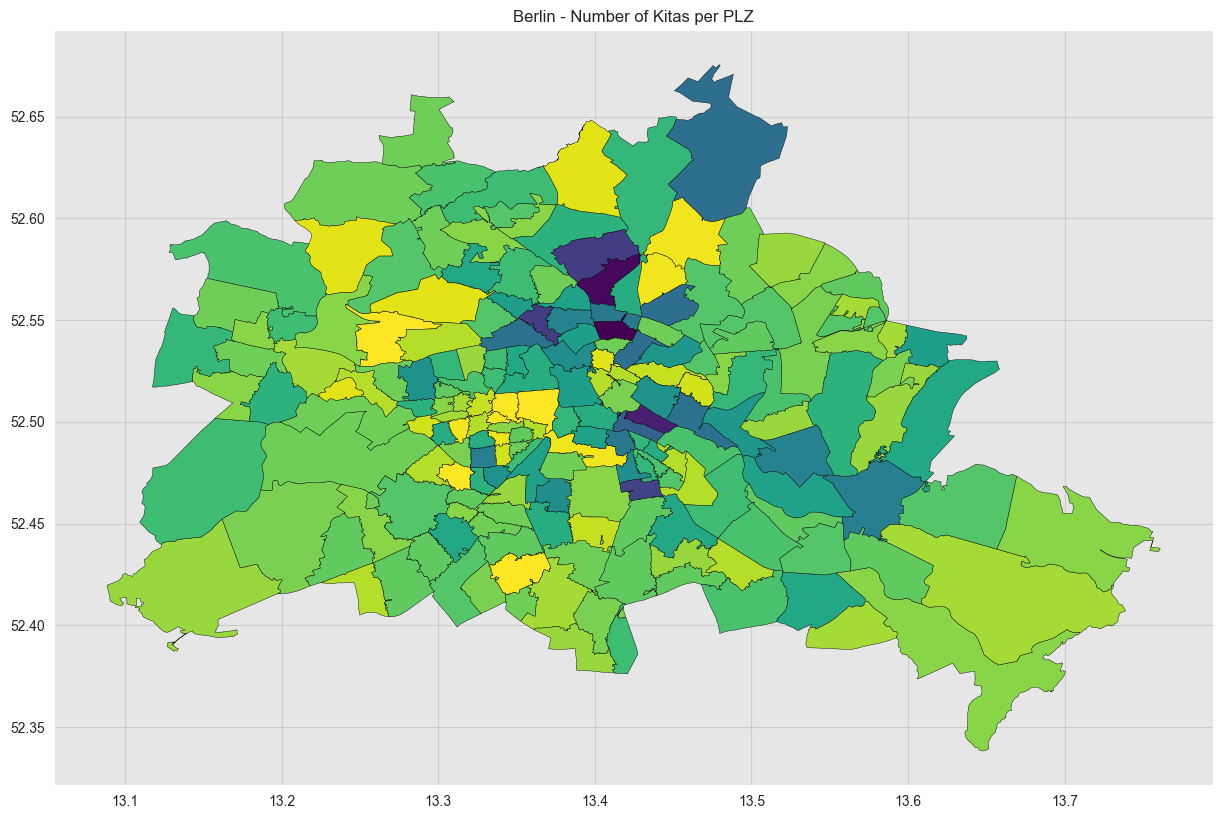

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='num_kitas_plz',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)
ax.set(
    title='Berlin - Number of Kitas per PLZ',
    aspect=1.3
);

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='num_kitas_plz',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)

mplleaflet.display(fig=fig)

As we see, comparing `plz` data without controlling for population can lead to misleading conclusions. Let us not compute the number of Kitas per capita per `district`. 

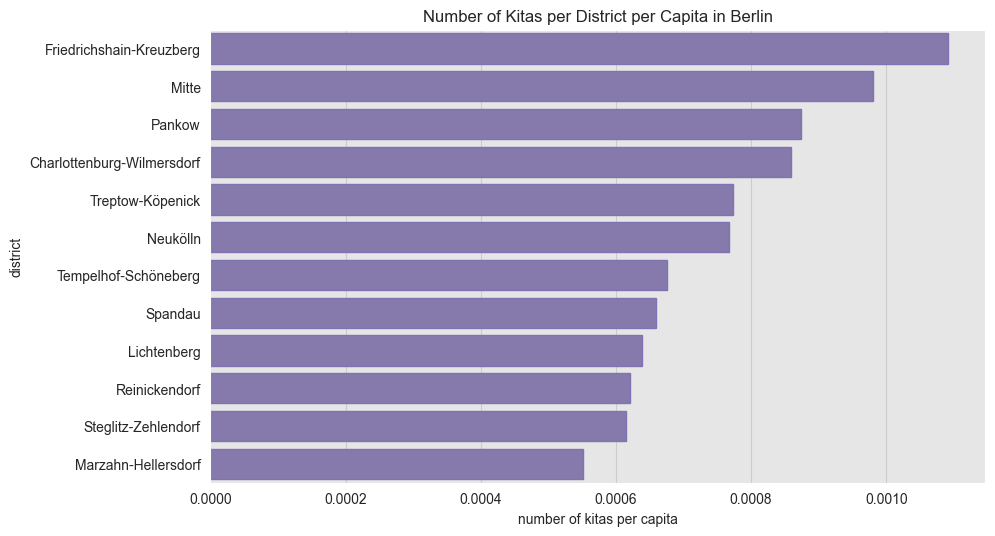

In [44]:
fig, ax = plt.subplots()

plz_df \
    .groupby(['district'], as_index=False) \
    .agg({'einwohner': np.sum, 'num_kitas_plz': np.sum}) \
    .assign(num_kitas_district_pc = lambda x: x['num_kitas_plz'].div(x['einwohner'])) \
    .sort_values('num_kitas_district_pc', ascending=False) \
    .pipe((sns.barplot, 'data'),
        x='num_kitas_district_pc',
        y='district',
        color=sns_c[4],
        edgecolor=sns_c[4],
        ax=ax,
    )

ax.set(
    title='Number of Kitas per District per Capita in Berlin',
    xlabel='number of kitas per capita',
    ylabel='district',
);

We see that the top 3 districts remain, but now Friedrichshain-Kreuzberg and Mitte are at the top. 

Next, we plot the number of Kitas per capita per `plz` (log-transform). 

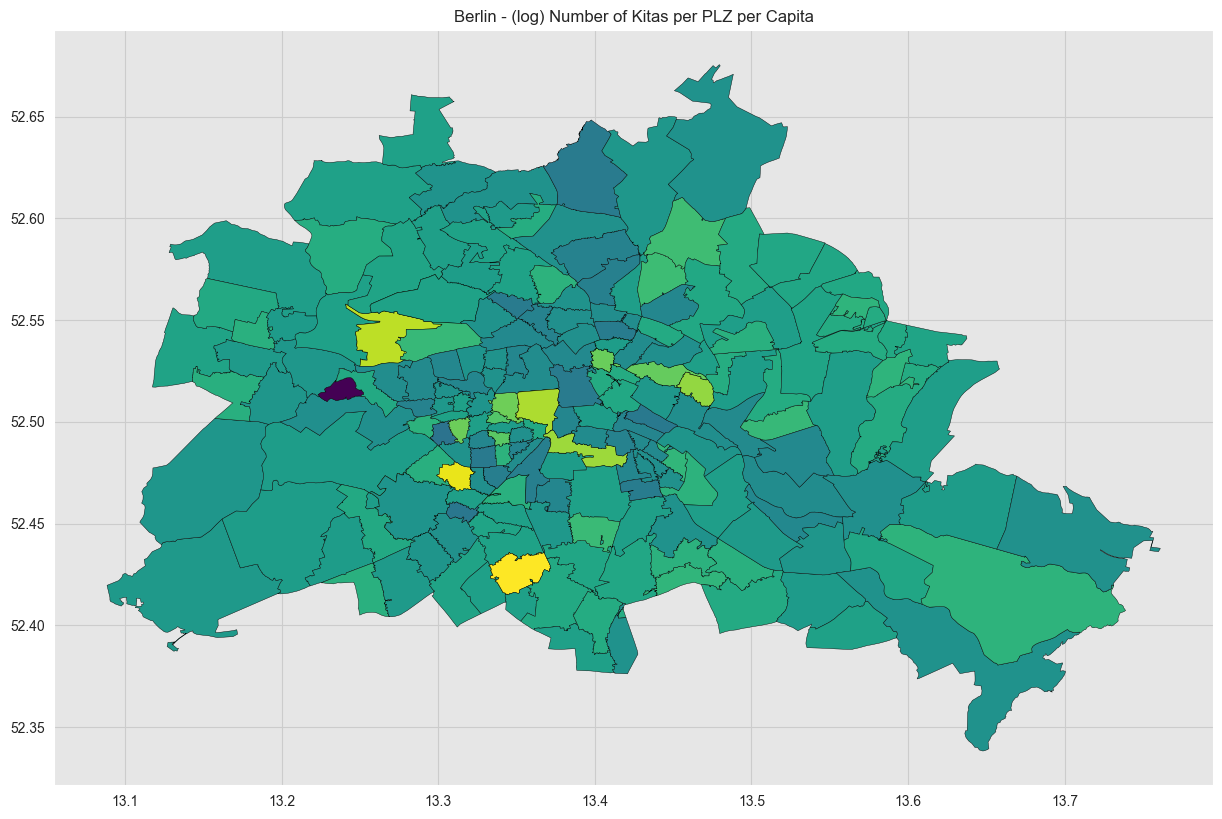

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='num_kitas_plz_pc_log',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)

ax.set(
    title='Berlin - (log) Number of Kitas per PLZ per Capita',
    aspect=1.3
);

We immediately see that there is a rather small `plz` with a high (log) number of Kitas. Let us find which one it is:

In [46]:
plz_df.sort_values('num_kitas_plz_pc', ascending=False).drop('geometry', axis=1).head()

plz  einwohner                    district  num_kitas_plz  spots_plz  \
18   14053        139  Charlottenburg-Wilmersdorf              3       70.0   
44   10709       8771  Charlottenburg-Wilmersdorf             18      824.0   
55   12165       4803         Steglitz-Zehlendorf              9      508.0   
146  10997      23800    Friedrichshain-Kreuzberg             42     1707.0   
68   10715      15464  Charlottenburg-Wilmersdorf             27     1027.0   

     num_kitas_plz_pc  num_kitas_plz_pc_log  
18           0.021583             -3.835862  
44           0.002052             -6.188834  
55           0.001874             -6.279771  
146          0.001765             -6.339771  
68           0.001746             -6.350433

We not locate the `plz` = 14053.

<div style="width: 100%">
    <iframe width="100%" height="600" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://maps.google.com/maps?width=100%25&amp;height=600&amp;hl=en&amp;q=Berlin%2014053+(Berlin%2014053)&amp;t=&amp;z=14&amp;ie=UTF8&amp;iwloc=B&amp;output=embed">
    </iframe>
</div>

This `plz` does not have many inhabitants, as it mainly encloses the [Olympiastadion](https://en.wikipedia.org/wiki/Olympiastadion_(Berlin)). We simply remove this data point from the map inorder to see a more faithful picture of the number of Kitas per capita per `plz`.

[Text(0.5, 1.0, 'Berlin - Number of Kitas per PLZ per Capita'), None]

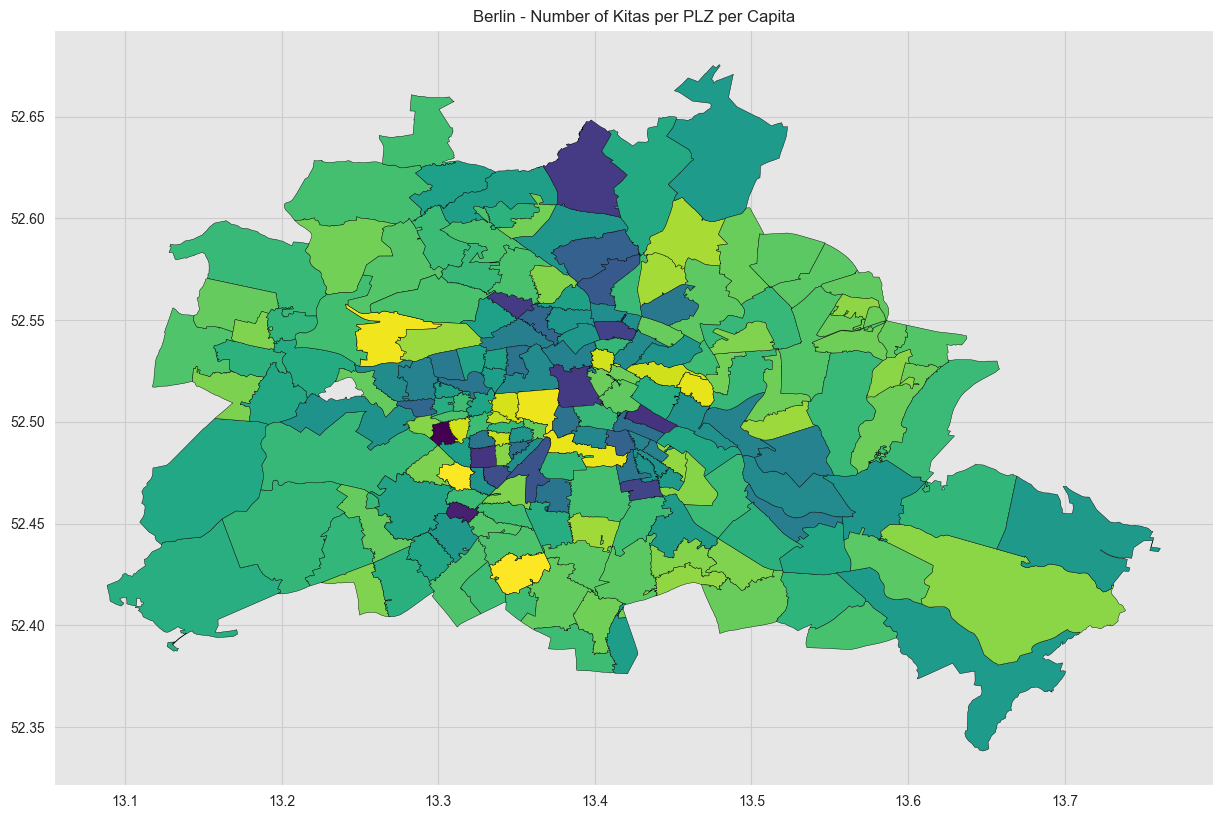

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.query('plz != "14053"').plot(
    ax=ax,
    column='num_kitas_plz_pc',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)

ax.set(
    title='Berlin - Number of Kitas per PLZ per Capita',
    aspect=1.3
)

In [48]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.query('plz != "14053"').plot(
    ax=ax,
    column='num_kitas_plz_pc',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3
)

mplleaflet.display(fig=fig)

## Number of Kitas, Population, Spots and Districts Relations

Finally, let us study the relations between number of kitas, spots and population per `plz`. These variables are naturally correlated:

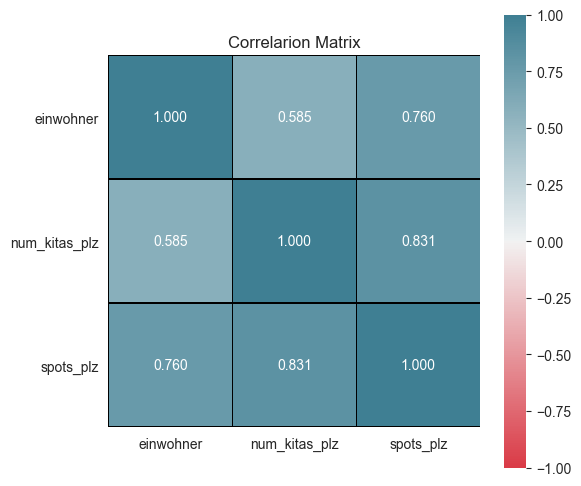

In [49]:
corr_mat = plz_df[['einwohner', 'num_kitas_plz', 'spots_plz']].corr()

fig, ax = plt.subplots(figsize=(6, 6))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(
    data=corr_mat, 
    vmin=-1.0, 
    vmax=1.0, 
    center=0, 
    cmap=cmap, 
    square=True,
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
ax.set(title='Correlarion Matrix');

We can visualize them in a scatter plot.

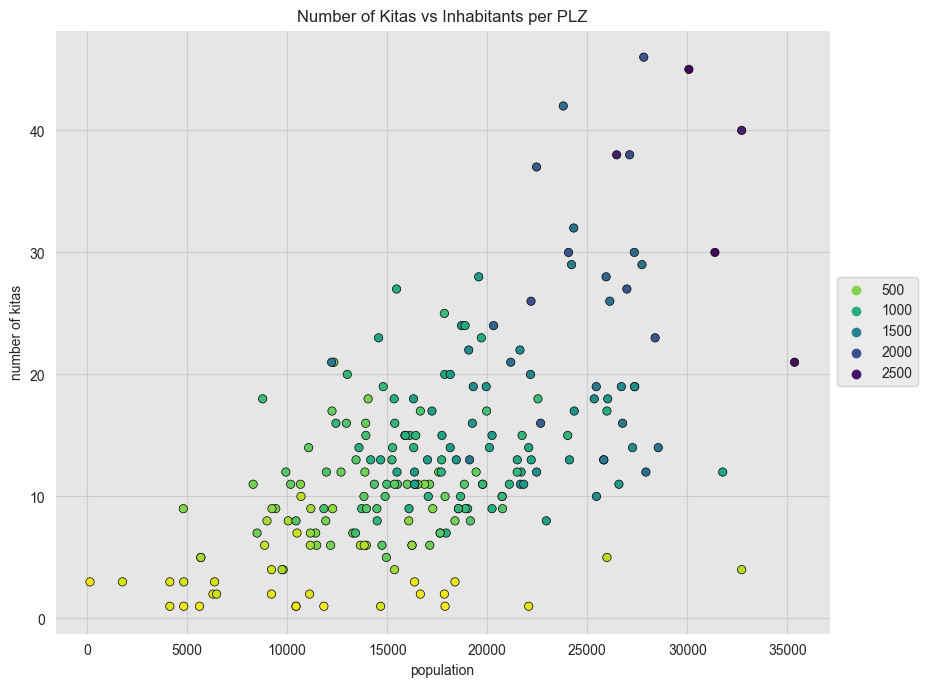

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
    hue='spots_plz',
    palette='viridis_r',
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

Let us encode the `district` as color and `spots` as size.

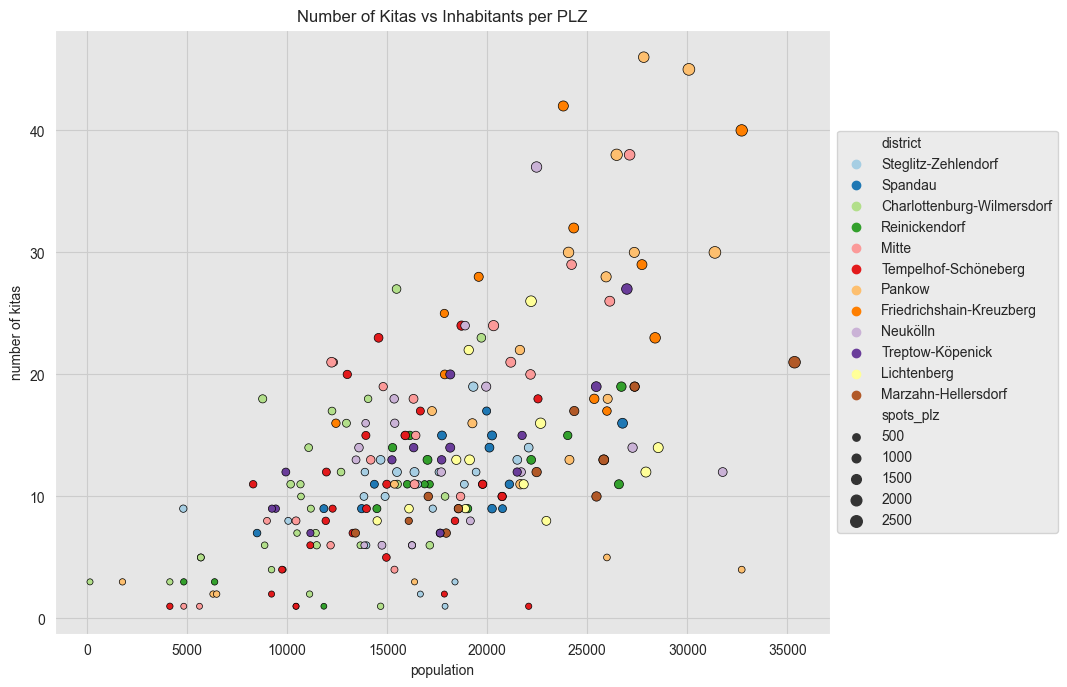

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
    size='spots_plz',
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

Another way to represent their relation is using a 3D-plot.

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=plz_df['einwohner'], 
    ys=plz_df['num_kitas_plz'], 
    zs=plz_df['spots_plz'], 
    c=to_hex(sns_c[0])
)
ax.set_title('Population, Number of Kitas ans Spots per PLZ iin Berlin', y=1.1);
ax.set(xlabel='population', ylabel='number of kitas', zlabel='spots');

NameError: name 'to_hex' is not defined

### Linear Regression Model

A natural question is: *How do the relations above depend on the district?* We of course expect different demographic distributions over different areas of the city. In this first iteration we run a simple linear regression model to estimate the variance explained of `num_kitas_plz` as a linear function of `einwohner` and `district`.

In [53]:
import statsmodels.formula.api as smf

model = smf.ols(formula='num_kitas_plz ~ einwohner + C(district)', data=plz_df)

result = model.fit()

print(result.summary())

OLS Regression Results                            
Dep. Variable:          num_kitas_plz   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           6.33e-21
Time:                        19:54:17   Log-Likelihood:                -696.16
No. Observations:                 214   AIC:                             1418.
Df Residuals:                     201   BIC:                             1462.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept             

We now look into the model predictions.

In [54]:
# Collect predictions.
plz_model_df = pd.concat([plz_df, result.get_prediction(plz_df).summary_frame()], axis=1)
# Compute errors.
plz_model_df = plz_model_df.assign(error = lambda x: x['mean'] - x['num_kitas_plz'])

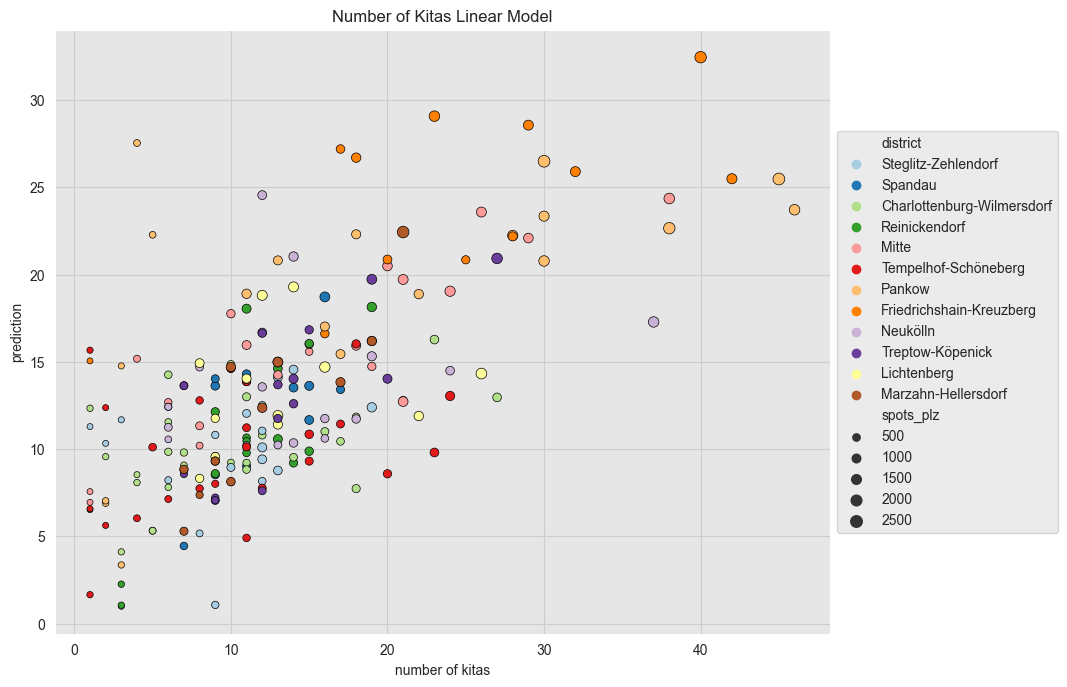

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='num_kitas_plz',
    y='mean',
    data=plz_model_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
    size='spots_plz',
    ax=ax
)

ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas Linear Model',
    xlabel='number of kitas',
    ylabel='prediction'
);

Finally, we plot the errors distribution:

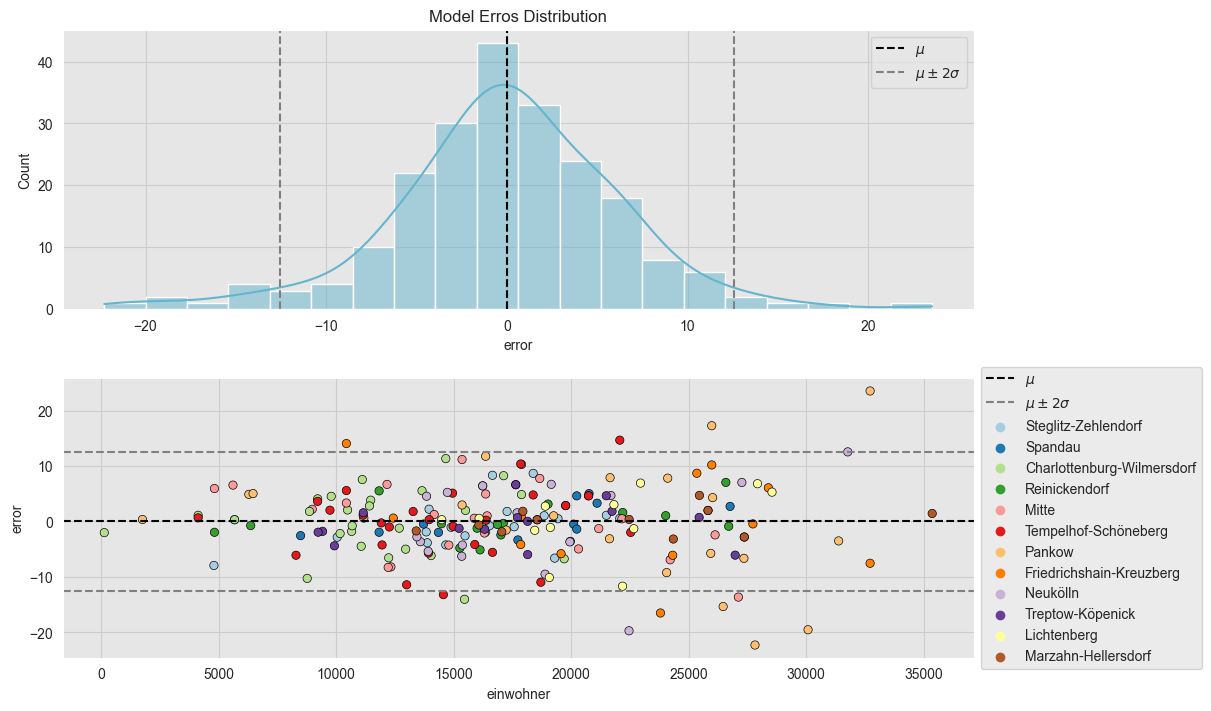

In [56]:
error_mean = plz_model_df['error'].mean()
error_std = plz_model_df['error'].std()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), constrained_layout=True)
sns.histplot(x='error', data=plz_model_df, color=sns_c[9], kde=True, ax=ax[0])
ax[0].axvline(x=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[0].axvline(x=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[0].axvline(x=error_mean - 2*error_std, color='gray', linestyle='--')
sns.scatterplot(x='einwohner', y='error', data=plz_model_df, hue='district', palette='Paired', edgecolor='black', ax=ax[1])
ax[1].axhline(y=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[1].axhline(y=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[1].axhline(y=error_mean - 2*error_std, color='gray', linestyle='--')

ax[0].legend()
ax[1].legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax[0].set(title='Model Erros Distribution');

The model is not perfect, but is a good place to start for a deeper analysis: ideally more data about the district demographics will be added and Bayesian methods like the ones presented in [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath.